# Modelling MPIA simulations with mascons


In [2]:
import gravann

# core stuff
import h5py
import numpy as np
import os
from sklearn.neighbors import NearestNeighbors
import pickle as pk

# plotting stuff
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
%matplotlib notebook

In [3]:
# This dictionary contains the names of some manually selected clusters for each sample.
cluster_dict = {
"sample_01": "cluster_2400",
"sample_02": "cluster_5486",
"sample_03": "cluster_2284",
"sample_04": "cluster_7315",
"sample_05": "cluster_3847",
"sample_06": "cluster_6137",
"sample_07": "cluster_2441",
"sample_08": "cluster_1970",
"sample_09": "cluster_1896"
}

# We import the data from MPIA containing pseudo-stable asteroid shapes.
key = "sample_01"
files = os.listdir("sample_vis_data/" + key)
files = sorted(files)
f = h5py.File("sample_vis_data/" + key + "/" + files[1],'r')
f2 = h5py.File("sample_vis_data/" + key + "/" + files[0], 'r')

In [4]:
# The file f contains the positions of all particles as well as the indices
# of those belonging to a cluster. Here we extract the largest ones.
dims = [(len(f[cluster][()]), cluster) for cluster in f.keys() if 'cluster' in cluster]
largest_clusters = sorted(dims,reverse=True)

In [52]:
# We have ordered the largest clusters, we may now extract one in particular by the rank (in terms of size)
rank = 0
cluster_name = largest_clusters[rank][1]
# Or uncomment the following line to get the preselected one
#cluster_name = cluster_dict[key]

print("Target: ", cluster_name)
# The particles idxs for this cluster
idx = f[cluster_name][()]
# The particle radius
radius = f2['radius'][()]
# Particle positions
x_raw = f['x'][()][idx]
y_raw = f['y'][()][idx]
z_raw = f['z'][()][idx]
print("Diameter: ", 2 * radius)
print("N. particles: ", len(x_raw))
filename = key+ "_" + cluster_name
print("File name: ", filename)


Target:  cluster_4439
Diameter:  0.00043088693800637674
N. particles:  4936
File name:  sample_01_cluster_4439


In [86]:
# We put xyz in a different shape to call NN
points = np.append(x_raw, np.append(y_raw,z_raw))
points = points.reshape((3,len(x_raw)))
points = np.transpose(points)

nbrs = NearestNeighbors(n_neighbors=5, algorithm='ball_tree').fit(points)
distances, indices = nbrs.kneighbors(points)

print("Minimum distance between particles: ", min(distances[:,1]))
print("Maximum distance between particles: ", max(distances[:,1]))

# We remove particles that are not "touching" at least 5 neighbours
unstable_points = np.where(distances[:, 3] > 2 * radius * 1.)[0]
print("Number of unstable points: ", len(unstable_points))
x = np.delete(x_raw, unstable_points, 0)
y = np.delete(y_raw, unstable_points, 0)
z = np.delete(z_raw, unstable_points, 0)


Minimum distance between particles:  0.0003979615304412529
Maximum distance between particles:  0.0004813383783622544
Number of unstable points:  75


In [127]:
# We subtract the mean so that the origin is the center of figure
x = x - np.mean(x)
y = y - np.mean(y)
z = z - np.mean(z)

# We scale so that the masses are at most 0.6 away from center
max_value = max([max(abs(it)) for it in [x,y,z]])
x = x / max_value * 0.6
y = y / max_value * 0.6
z = z / max_value * 0.6

# We also create a hollow sphere inside the asteroid. 
x_pos = 0.1
y_pos = -0.13
z_pos = -0.045
hole_r = 0.1
mask = ((x-x_pos)**2 +(y-y_pos)**2+(z-z_pos)**2) > hole_r

# We record a unitary mass everywhere but in the mask (Hollow non uniform asteroid)
masses_nu = np.array([0]*len(x))
masses_nu[mask] = 1.

masses = np.array([1]*len(x))

# We put xyz in a different shape (point_cloud)
points = np.append(x, np.append(y,z))
points = points.reshape((3,len(x)))
points = np.transpose(points)

# We make the total mass unitary
masses_nu = masses_nu / sum(masses_nu)

### Visualization via matplotlib

<IPython.core.display.Javascript object>


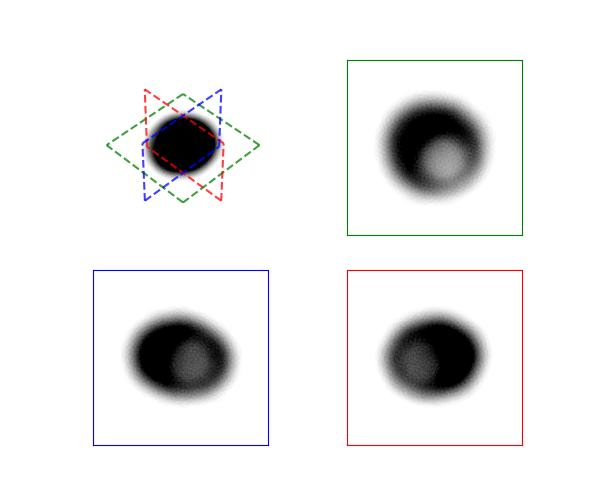

In [133]:
fig = gravann.plot_mascon(points,masses_nu, alpha=0.003)

In [134]:
# Saving the mascon model
with open("mascons/planetesimal.pk", "wb") as file:
    pk.dump((points, masses, filename), file)

In [135]:
# Saving the mascon model
with open("mascons/planetesimal_nu.pk", "wb") as file:
    pk.dump((points, masses_nu, filename), file)